In [1]:
# based on code by https://www.youtube.com/watch?v=ADV-AjAXHdc&list=PL2VXyKi-KpYuTAZz__9KVl1jQz74bDG7i&index=4

import cv2
from matplotlib import pyplot as plt

In [2]:
# https://stackoverflow.com/questions/28816046/
# displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis("off")

    # Display the image.
    ax.imshow(im_data, cmap="gray")

    plt.show()

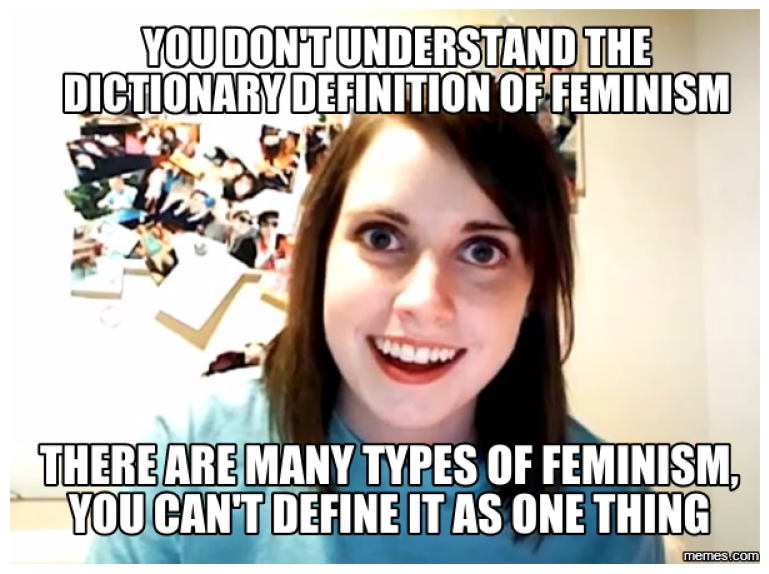

In [5]:
meme_path = "memes/210513.png"
display(meme_path)

Compare with PIL's Image open - seems like the size is different. Perhaps using the display function allows for more configuration.

* According to the internet in brief, PIL uses python and C under the hood while cv2 is written with C and C++ --> cv2 is probably faster.
* cv2 is a computer vision library, while Pillow specialises in image processing
* Pillow is simple and probably a good starting point.

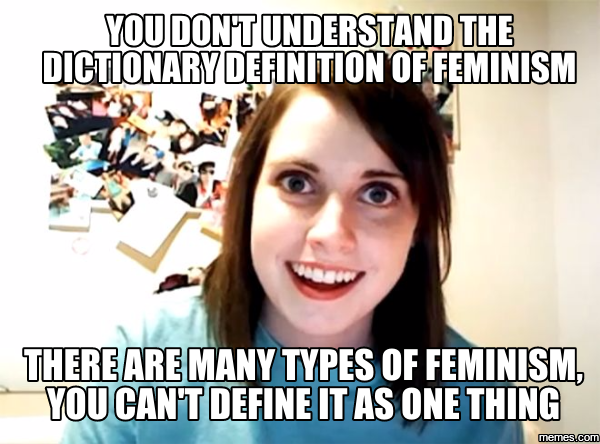

In [6]:
from PIL import Image

img = Image.open(meme_path)
img

## Invert image colours

In [7]:
img = cv2.imread(meme_path)
inverted_meme = cv2.bitwise_not(img)
cv2.imwrite("temp/inverted_meme.jpeg", inverted_meme)

True

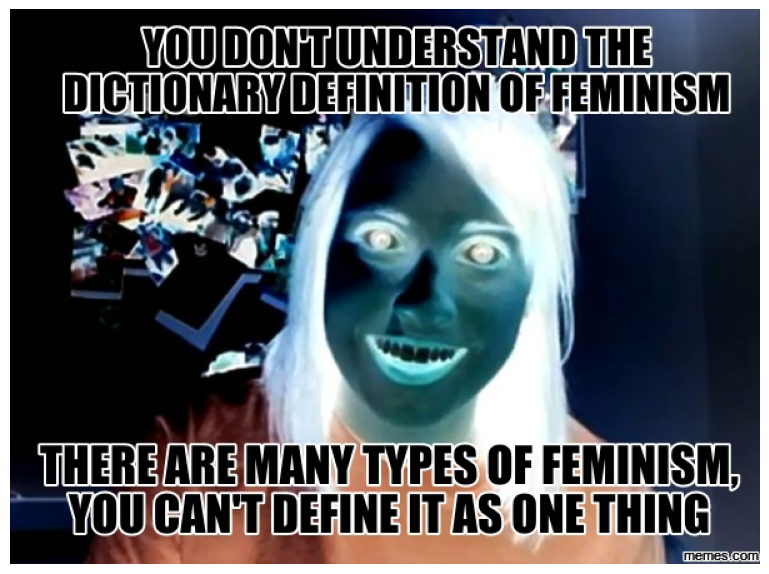

In [8]:
display("temp/inverted_meme.jpeg")

### Rescaling

To ensure best performance in OCR, the image can be rescaled such that the height of characters is in an optimal range (see tesseract in cv2 for more information).

### Binarize

1. Grayscale image
2. Transform into just black and white

In [9]:
def greyscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [10]:
grey_image = greyscale(img)
cv2.imwrite("temp/grey_image.jpeg", grey_image)

True

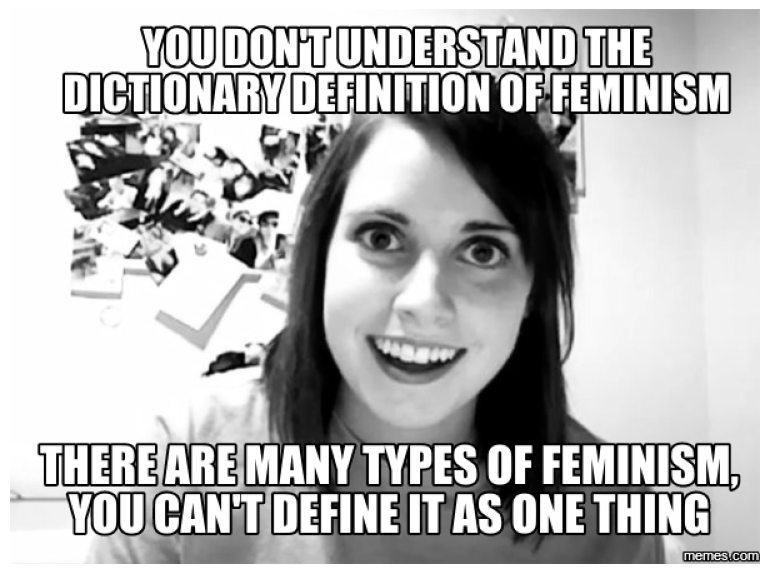

In [11]:
display("temp/grey_image.jpeg")

The different values in the threshold should be adjusted based on the image and how best to allow the text to be seen. In this case, the colours of the words are very uniform and this halfway point threshold seems to work fine. However, if it is a scanned handwritten text document, the values may have to be lowered for example.

This binarisation helps to remove unnecessary hues (e.g., shades in the background) which may throw off the OCR.

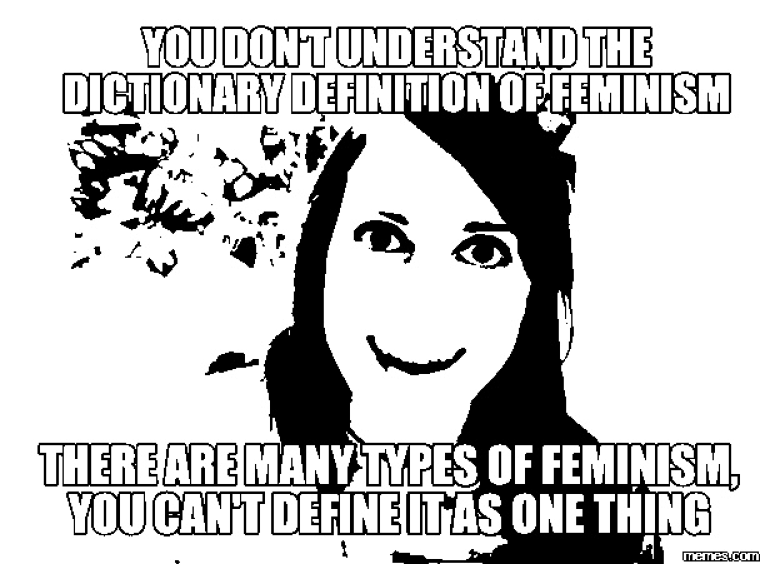

In [12]:
thresh, im_bw = cv2.threshold(grey_image, 100, 255, cv2.THRESH_BINARY)
cv2.imwrite("temp/black_white.jpeg", im_bw)
display("temp/black_white.jpeg")

### Noise removal

To remove pixels that do not correspond to text.

### Erosion/Dilation

Can thin/thicken the text

### Rotation/Deskewing

OCR is designed to work with vertically aligned text --> if text is slanted, it has to be rotated back in order for OCR to read it 
well.

Note that the skewed image **cannot** have a border in order for the deskewing to work because it is done through looking at the bounding borders of the text and figuring out the angle of rotation to rotate it back.

## Py Tesseract

In [55]:
import pytesseract
from PIL import Image
import numpy as np

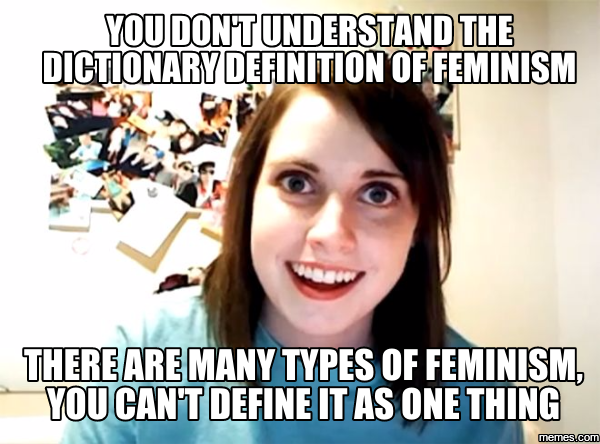

In [29]:
simple_meme = "memes/210513.png"
img_tess = Image.open(simple_meme)



img_tess

In [69]:
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # # Apply GaussianBlur to reduce noise and improve contour detection
    # blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # # Apply adaptive thresholding
    # thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    #                                cv2.THRESH_BINARY_INV, 11, 2)
    thresh, im_bw = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # cv2.imwrite("temp/black_white.jpeg", im_bw)

    # try to use erosion followed by dilation to remove some random dots in the black and white image
    # Use morphological operations to remove small noise and to close gaps in the text regions
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    morph = cv2.morphologyEx(im_bw, cv2.MORPH_CLOSE, kernel)

    return morph, thresh

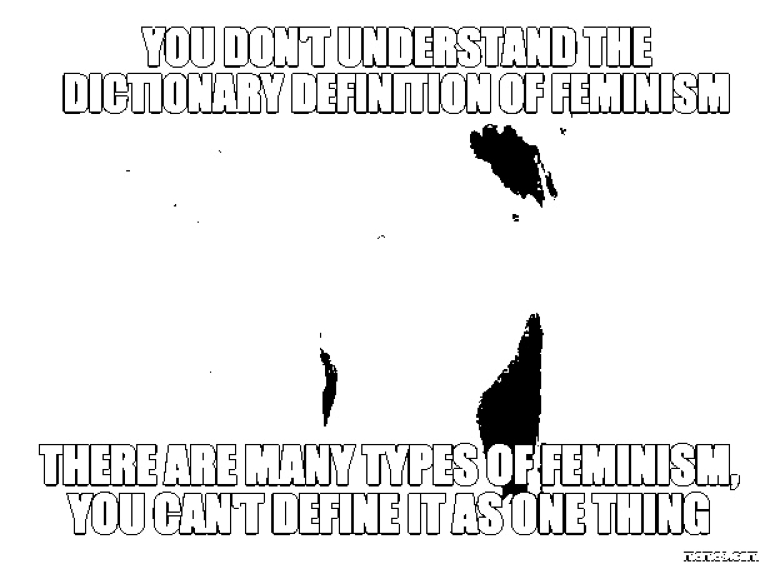

In [70]:
morphed, thresh = preprocess_image(simple_meme)
cv2.imwrite("temp/morphed.jpeg", morphed)
display("temp/morphed.jpeg")

In [73]:
im = cv2.imread("temp/morphed.jpeg")
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(gray, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[
    -2:
]
idx = 0
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    roi = im[y : y + h, x : x + w]
    cv2.imwrite(str(idx) + ".jpg", roi)
    # cv2.rectangle(im,(x,y),(x+w,y+h),(200,0,0),2)
cv2.imshow("img", im)
cv2.waitKey(0)

In [65]:
def show_ocr(image_path):
    morphed_image = Image.open(image_path)
    ocr_result = pytesseract.image_to_string(morphed_image)
    return ocr_result

In [72]:
show_ocr("temp/morphed.jpeg")

'(OUDONMUNDERSTANDIINE\nDICTIONARY DEFINTIONIOR FEMINISM\n\nTHEREARE\\MAN YAN RESO RFEMINIs\nOU CANATUEFINENASIONEITE\n\n'

It seems like even if the text if fairly obvious to the human eye, pytesseract does not read them as easily as it takes the surrounding noise into account. According to [this source](https://www.youtube.com/watch?v=oyqNdcbKhew), easyocr and keras_ocr can read text from image better. Pytesseract can be left more for scanned documents without so much information in the background.